# PyStan gamma-Poisson MLM example for AAS 227

Created 2014-11-04 by Tom Loredo for IAC Winter School

Adapted for AAS227 2016-01-06

This notebook demonstrates the use of the Stan probabilistic programming language to implement a basic Bayesian multilevel model, the gamma-Poisson model, in a mock astronomical setting. A population of sources is modeled as having fluxes distributed according to a *gamma distribution* (a power-law distribution with an exponential upper cutoff, like a *Schecter function*, but constrained to be normalizable at small fluxes).  Noisy observations are simulated, based on simple Poisson photon counting models for observations of varied exposure (and thus varied precision or signal-to-noise). The goal is to recover the population distribution (i.e., the power-law slope and the cutoff flux) from the observed photon counts.

This is but a caricature of what would be required in analyses of real data pertaining to the number counts, $\log N$&ndash;$\log S$, or number-size distribution of a population.  Most notably, there is no background, no detection threshold, and thus no accounting for selection effects (which are thus absent in the simulations).  It is meant only as a simple demonstration of the potential of Stan and other probabilistic languages for astronomical data analysis.

The notebook was developed using the following tools:
* Anaconda Python 2.7.11 ([install Anaconda](http://docs.continuum.io/anaconda/install)), which includes the standard PyData packages (NumPy, SciPy, matplotlib, etc.)
* Jupyter 4.0 (included in recent Anaconda installations)
* PyStan 2.9.0.0 (install the current PyStan via `pip install pystan`)

It also uses two supporting Python modules:
* `shrinkage_plot`
* `stanfitter`

The `shrinkage_plot` module provides a helper function to produce a simple parallel coordinates plot depicting shrinkage of flux estimates. "Shrinkage" is a technical term in multivariate statistics, referring to an effect related to what astronomers know as correction for Eddington bias. 

The `stanfitter` module provides a more "Pythonic" wrapper around PyStan's interface to Stan.  It is being maintained separately on GitHub (see [`stanfitter` on GitHub](https://github.com/tloredo/stanfitter)).  The current version is provided in this notebook's GitHub repo for simplicity. It is not well documented (I've been using it in the classroom, teaching its use interactively in lab sessions). Documentation is forthcoming, but this notebook illustrates key capability by example.

For information about PyStan and the Stan language, visit:

https://pystan.readthedocs.org/en/latest/getting_started.html

## Setup

In [65]:
import numpy as np
import scipy
from scipy import stats
import matplotlib as mpl

# Pollute the namespace!
from matplotlib.pyplot import *
from scipy import *

from stanfitter import StanFitter
from shrinkage_plot import shrinkage_plot

In [66]:
# Get TL's interactive plotting customizations if availalbe.
try:
    import myplot
    from myplot import close_all, csavefig
    ion()
    # myplot.tex_on()
    csavefig.save = False
except:
    pass

In [67]:
%matplotlib inline

## Stan code for a gamma-Poisson MLM

Stan is a sophisticated computing language. When used via PyStan, Stan code may be included in a string (as in the next cell), or in a separate file. This notebook's repo includes a file, "gamma-poisson.stan", that shows what a Stan file looks like (it's just the string below, in a file of its own); it is not used by this notebook.

Note here that Stan defines the gamma distribution's cutoff, not in terms of a scale parameter (i.e., the flux cutoff), but in terms of the *inverse* scale, traditionally referred to as the $\beta$ parameter. To handle this, we use Stan's capability to define **transformed parameters**, i.e., functions of the parameters that will actually be used in Stan's calculation.

In [68]:
# Stan code defining a gamma-Poisson MLM for number counts (log N - log S)
# fitting:
code = """
data {
    int<lower=0> N; 
    int<lower=0> counts[N];
    real  exposures[N]; 
} 

parameters {
    real<lower=0> alpha; 
    real<lower=0> beta;
    real<lower=0> fluxes[N];
}

transformed parameters {
    real<lower=0> flux_cut;
    flux_cut <- 1./beta;
}

model {
    alpha ~ exponential(1.0);
    beta ~ gamma(0.1, 0.1);
    for (i in 1:N){
        fluxes[i] ~ gamma(alpha, beta);
        counts[i] ~ poisson(fluxes[i] * exposures[i]);
  }
}
"""

## Define the problem

**Choose one of the following two options (stellar or GRB flux dist'ns)**

We define some variables here that describe how the data will be simulated and modeled.

In [69]:
# Setup "true" model and design parameters for GRB observations:
if True:
    # Define gamma dist'n parameters alpha & F_cut:
    F_cut = 10.  # peak flux of bright BATSE GRB, photons/s/cm^2
    alpha = .66  # power law part has exponent alpha-1; requires alpha > 0

    # Variables describing the data sample:
    n_s = 20
    area = 335.  # Single BATSE LAD effective area, cm^2
    # Fake projected areas for a triggered detector:
    areas = area*stats.uniform(loc=.5, scale=.5).rvs(n_s)
    exposures = .064*areas  # use 64 ms peak flux time scale

# OR, setup "true" model and design parameters for stellar observations:
elif:
    # Define gamma dist'n parameters alpha & F_cut:
    Jy_V0 = 3640.  # V=0 energy flux in Jy
    phi_V0 = 1.51e7 * 0.16 * Jy_V0  # V=0 photon number flux (s m^2)^{-1}
    V_cut = 24.  # V magnitude at rollover
    F_cut = phi_V0 * 10.**(-0.4*V_cut)  # flux at rollover
    alpha = .4  # power law part has exponent alpha-1; requires alpha > 0

    # Variables describing the data sample:
    n_s = 25
    area = pi*(8.4**2 - 5**2)  # LSST primary area (m^2)
    exposures = 10.*area*ones(n_s)  # LSST single-image integration time * area
    mid = n_s//2
    exposures[mid:] *= 10  # last half use 10x default exposure

SyntaxError: invalid syntax (<ipython-input-69-3088fc84c70b>, line 15)

## Simulate a dataset

In [70]:
# Define the true flux dist'n as a gamma dist'n.
beta = 1./F_cut  # Stan uses the inverse scale
ncdistn = stats.gamma(a=alpha, scale=F_cut)

# Sample some source fluxes from the flux population dist'n.
fluxes = ncdistn.rvs(n_s)


# Generate observations of the flux sample.
def gen_data():
    """
    Simulate photon count data from the Poisson distribution, gathering
    the data and descriptive information in a dict as needed by Stan.
    """
    n_exp = fluxes*exposures  # expected counts for each source
    counts = stats.poisson.rvs(n_exp)
    return dict(N=n_s, exposures=exposures, counts=counts)

data = gen_data()

## Invoke Stan to build the model

Invoke stan via the StanFitter class. It takes Stan code either as a string (as here), or via a file.

Stan will "write" and compile a C++ executable implementing the model, a
posterior sampler, Markov chain output analysis functions, and an optimizer.
This takes a bit of time. StanFitter will cache the Stan products so
subsequent runs of the script need not rebuild the model from scratch.

**NOTE:** PyStan's compilation and simulation progress will be reported on stdout. *When using PyStan, make sure you check your Jupyter session's console window for activity and warnings.* If Stan has trouble, you likely won't see any activity in the notebook indicating there was a problem. In particular, if there's a bug in the Stan code, the error message will appear on the console, not in the notebook.

In [71]:
fitter = StanFitter(code, data)  # use code string in this notebook (above); StanFitter also supports external files

Using cached StanModel from cached-model-Anon-74ff5b27d9faad39b43b6b79870bc4f9.pkl...


## Do MCMC posterior sampling via Hamiltonian Monte Carlo

A `StanFitter` instance has a `sample()` method that invokes Stan's default HMC "No-U-Turn Sampler" (NUTS). It returns a `Fit` object providing access to many results of the sampling run.

Remember, *progress is logged to the console window*.

In [72]:
# Run 4 chains of length 2000 (Stan will use 1/2 of each for burn-in).
fit = fitter.sample(8000, 4)

### Quick summary

Print a quick textual summary of the MCMC results for all parameters and
the log posterior density, log_p.  For the vector parameter, `fluxes`, a
summary is printed for *every* element, which may not be desired if there
are many such parameters.

In [73]:
print fit

Inference for Stan model: anon_model_74ff5b27d9faad39b43b6b79870bc4f9.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        0.93  3.9e-3   0.26   0.51   0.75    0.9   1.09   1.52 4403.0    1.0
beta         0.14  7.5e-4   0.05   0.06    0.1   0.13   0.17   0.25 4480.0    1.0
fluxes[0]    15.8    0.01   1.04  13.82  15.07  15.77  16.49  17.88 5334.0    1.0
fluxes[1]    3.17  5.6e-3   0.41   2.43   2.89   3.16   3.44   4.03 5334.0    1.0
fluxes[2]    6.79 10.0e-3   0.73   5.45   6.28   6.76   7.27   8.26 5334.0    1.0
fluxes[3]    2.56  5.0e-3   0.37   1.89    2.3   2.54    2.8   3.33 5334.0    1.0
fluxes[4]    7.54    0.01   0.83    6.0   6.95   7.51   8.09   9.25 5334.0    1.0
fluxes[5]   10.09  9.8e-3   0.71   8.74    9.6  10.07  10.56  11.52 5334.0    1.0
fluxes[6]     0.5  2.3e-3   0.17   0.23   0.38   0.48    0.6   0.88 5334

### Check convergence and mixing of chains

After sampling, the `fit` object has attributes for each parameter and
transformed parameter in the model; the attributes provide access to
the chains (4 chains in this case), a pooled and thinned collection of samples from all chains, and
various summary statistics for each parameter (including MCMC output
diagnostics).

Verify convergence by looking at the Gelman-Rubin $\hat R$ statistic for every
parameter of interest; it should be within a few % of 1. Also, examine the effective sample size (ESS) as a first indication of how well the chains are mixing. As a rule of thumb, if you aim to report 95% credible regions for parameters, you want the ESS to be at least a few thousand.

**Pontification:** Too many Bayesian analyses in the astronomical literature fail to describe adequate MCMC output analysis (most likely because the authors failed to *do* adequate output analysis). For brevity, this notebook presents the *bare minimum* of what you should be doing. If your problem requires MCMC, then it also requires you to really learn about how to do MCMC right. A good starting point is this standard reference:

* *Handbook of Markov Chain Monte Carlo* ([authors' web site](http://www.mcmchandbook.net/HandbookTableofContents.html), [publisher's web site](https://www.crcpress.com/Handbook-of-Markov-Chain-Monte-Carlo/Brooks-Gelman-Jones-Meng/9781420079418))

Note that some of the key chapters are *freely available* at the authors' web site. Don't 
use MCMC methods unless you've at least read Charlie Geyer's ["Introduction to MCMC"]{http://www.mcmchandbook.net/HandbookChapter1.pdf), esp. section 1.11 on "The Practice of MCMC." Not all experts practitioners agree with all of Geyer's advice (particularly in regard to the value of parallel chains), but the vast majority of his recommendations and insights are shared by experts. Some notable excerpts, to motivate you:

> There is a great deal of theory about convergence of Markov chains. Unfortunately, none
of it can be applied to get useful convergence information for most MCMC applications.
Thus most users find themselves in the... situation we call *black box MCMC*....

> When you are in the black box situation, you have no idea how long runs need to be to
get good mixing (convergence rather than pseudo-convergence)....

> Your humble author has a dictum that the least one can do is to make an overnight run.
What better way for your computer to spend its time? In many problems that are not too
complicated, this is millions or billions of iterations. If you do not make runs like that, you
are simply not serious about MCMC. Your humble author has another dictum (only slightly
facetious) that one should start a run when the paper is submitted and keep running until the
referees’ reports arrive. This cannot delay the paper, and may detect pseudo-convergence.

The [PyMC](https://pymc-devs.github.io/pymc/) package provides several tools for MCMC output analysis. Two R packages that statisticians have developed for MCMC output analysis are [`coda`](https://cran.r-project.org/web/packages/coda/index.html) and [`BOA`](http://www.public-health.uiowa.edu/boa/). You may be able to acess them from Python via [`RPy2`](http://rpy.sourceforge.net/) (note that Anaconda now has an [R-Essential channel](https://www.continuum.io/blog/developer/jupyter-and-conda-r), providing support for many popular R packages in conda environments).

In [74]:
# For scalar params, just make a table of Rhat and ESS.
scalars = [fit.alpha, fit.beta, fit.flux_cut]
print '*** Checks for convergence, mixing ***'
print 'Rhat, ESS for scalar params:'
for param in scalars:
    print '    {0:12s}:  {1:6.3f}  {2:6.0f}'.format(param.name, param.Rhat, param.ess)

*** Checks for convergence, mixing ***
Rhat, ESS for scalar params:
    alpha       :   1.000    4403
    beta        :   1.000    4480
    flux_cut    :   1.000    4074


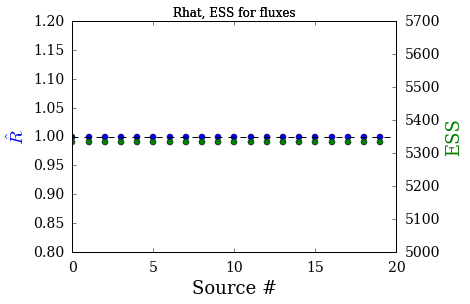

In [75]:
# For the vector of latent fluxes, make a plot.
flux_Rhats = [fit.fluxes[i].Rhat for i in range(n_s)]
figure()
subplots_adjust(top=.925, right=.875)  # make room for title, right ESS labels
ax_left = subplot(111)  # left axis for Rhat
plot(range(n_s), flux_Rhats, 'ob')
ylim(0.8, 1.2)
axhline(y=1., ls='--', color='k')
title('Rhat, ESS for fluxes')
xlabel('Source #')
ylabel(r'$\hat R$', color='b')
ax_right = twinx()  # right axis for ESS
flux_ess = [fit.fluxes[i].ess for i in range(n_s)]
plot(range(n_s), flux_ess, 'og')
title('Rhat, ESS for fluxes')
ylabel('ESS', color='g')

### Check mixing of chains

Check mixing further by examining trace plots of parameters of interest,
making sure there are no obvious trends or strong, long-range correlations.
Here we look at the scalars alpha, beta (flux_cut is derived from beta so needn't be separately checcked). Another common diagnostic (skipped here) is to examine the autocorrelation functions of traces (in fact, these can be used to compute the ESS).

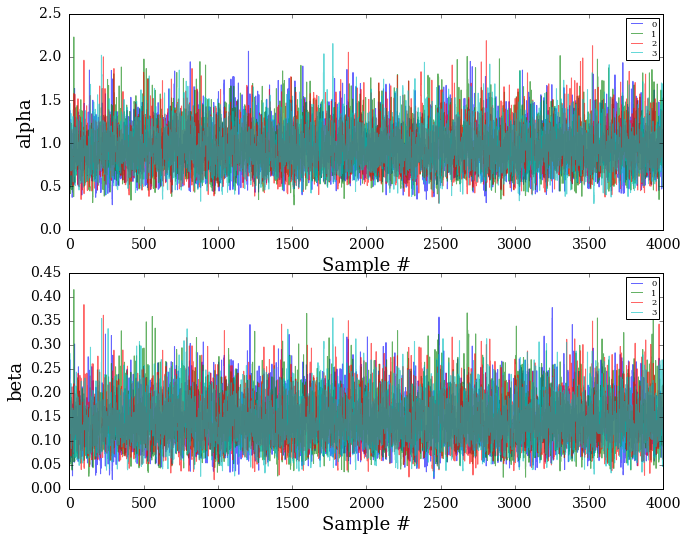

In [76]:
# Plot traces of scalar parameters; distinguish the 4 parallel chains by color.
f=figure(figsize=(10,8))
ax=f.add_subplot(2,1,1)
fit.alpha.trace(axes=ax,alpha=.6)  # without `axes`, this will make its own fig
ax=f.add_subplot(2,1,2)
fit.beta.trace(axes=ax,alpha=.6)

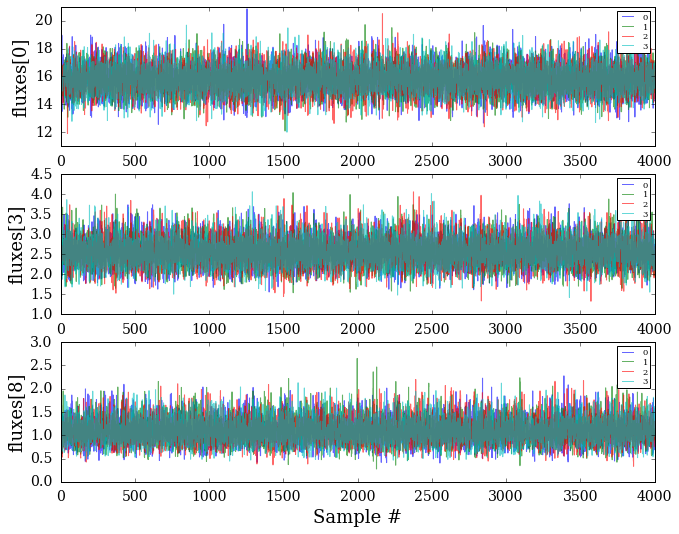

In [77]:
# Look at traces for some fluxes.
f=figure(figsize=(10,8))
ax=f.add_subplot(3,1,1)
fit.fluxes[0].trace(axes=ax,alpha=.6)
ax=f.add_subplot(3,1,2)
fit.fluxes[3].trace(axes=ax,alpha=.6)
ax=f.add_subplot(3,1,3)
fit.fluxes[8].trace(axes=ax,alpha=.6)

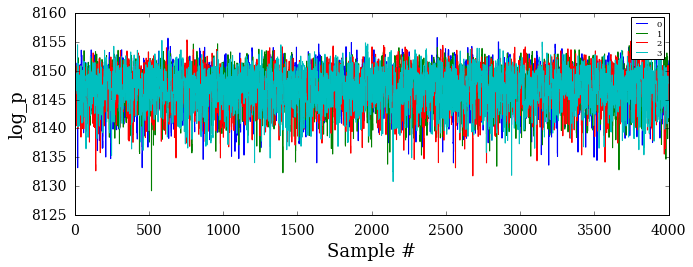

In [78]:
# Look at the log_p trace plot.
fit.log_p.trace()  # creates a new fig by default

## Inferences

Now, **after** the checks, we're ready to make some inferences.

Show the joint distribution for (alpha,flux_cut) as a scatterplot, and
marginals as histograms.

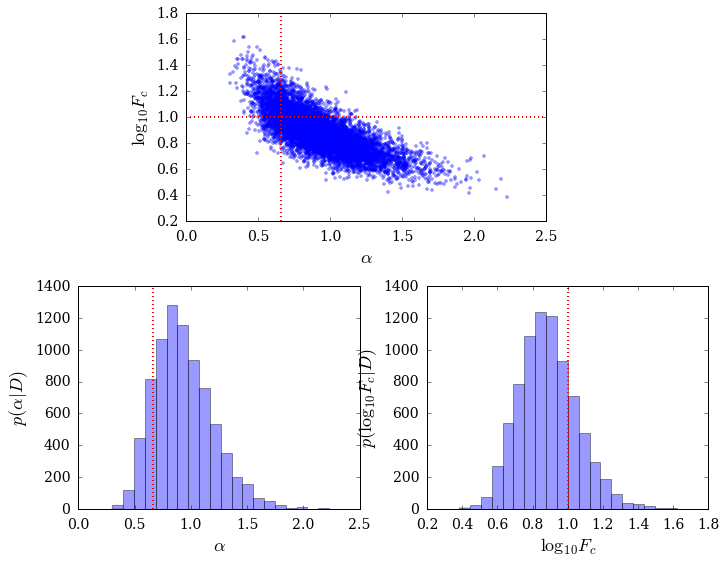

In [79]:
f = figure(figsize=(10,8))
subplots_adjust(bottom=.1, left=.1, right=.975, wspace=.24, )

# subplot(232)  # joint at mid-top
f.add_axes([.25, .6, .5, .36])
plot(fit.alpha.thinned, log10(fit.flux_cut.thinned), 'b.', alpha=.4)
# crosshair showing true values:
xhair = { 'color' : 'r', 'linestyle' : ':' , 'linewidth' : '2'}
axvline(alpha, **xhair)
axhline(log10(F_cut), **xhair)
xlabel(r'$\alpha$')
ylabel(r'$\log_{10}F_{c}$')

subplot(223)  # marginal for alpha bottom-left
hist(fit.alpha.thinned, 20, alpha=.4)
axvline(alpha, **xhair)
xlabel(r'$\alpha$')
ylabel(r'$p(\alpha|D)$')

subplot(224)  # marginal for F_cut bottom-right
hist(log10(fit.flux_cut.thinned), 20, alpha=.4)
axvline(log10(F_cut), **xhair)
xlabel(r'$\log_{10}F_{c}$')
ylabel(r'$p(\log_{10}F_c|D)$')

Make a plot illustrating shrinkage of point estimates for the fluxes. For this example, the shrinkage is pretty minimal for most fluxes, but significant for those with the noisiest measurements (some noisy cases may have ML estimates that fall out of bounds in the plot).

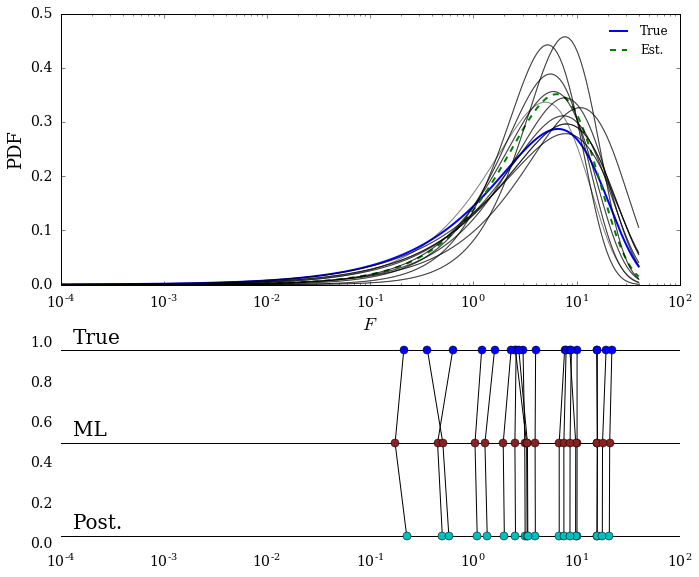

In [80]:
# Max likelihood estimates:
F_ml = data['counts']/data['exposures']
# Means of marginal posteriors:
F_post = array([fit.fluxes[i].mean for i in range(n_s)])
#F_vals = linspace(.0001, 1.1*fluxes.max(), 200)  # fluxes for PDF plot
u = max(1.1*fluxes.max(), 4*F_cut)
F_vals = logspace(-4, log10(u), 200)  # fluxes for PDF plot
pdf_vals = ncdistn.pdf(F_vals)  # true number count dist'n over F_vals
ax_pdf, ax_pts = shrinkage_plot(F_vals, pdf_vals, fluxes, F_ml, F_post, r'$F$',
                 log_x=True, log_y=False)

# Get a 'best fit' set of parameters by finding the sample with highest
# posterior density; this would be a bad idea in high dimensions (use Stan's
# optimizer in such cases).
i = fit.log_p.thinned.argmax()
a, F = fit.alpha.thinned[i], fit.flux_cut.thinned[i]
# Plot the PDF for the best-fit model.
best = stats.gamma(a=a, scale=F)
ax_pdf.semilogx(F_vals, F_vals*best.pdf(F_vals), 'g--', lw=2, label='Est.')
ax_pdf.legend(frameon=False)

# Show the PDFs for some posterior samples.
for i in 49*linspace(1,10,20,dtype=int):  # every 49th sample
    a, F = fit.alpha.thinned[i], fit.flux_cut.thinned[i]
    distn = stats.gamma(a=a, scale=F)
    ax_pdf.semilogx(F_vals, F_vals*distn.pdf(F_vals), 'k', lw=1, alpha=.5, label=None)